<a href="https://colab.research.google.com/github/siddharth1292/projects/blob/main/LabAnalysis7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Goal of this analysis
The predicted rotation due to driving the pendulum is given by

$\Delta \theta = -\frac{2 b \Delta a}{a^2 - b^2} \approx -\frac{ab}{a^2-b^2}\frac{\Delta U}{U}f(\phi) \approx -\frac{b}{a}\frac{\Delta U}{U}f(\phi) $, with 

$f(\phi) = \cot(2\phi)$ (my formula)

or

$f(\phi) = \frac{{\pi}/{2} - \phi}{2 \tan(\phi)}$ (Schumacher and Tarbet eq 19)

or

$f(\phi) = \frac{{\pi}/{2} - \phi}{2 \sin(\phi)}$ (Schumacher and Tarbet eq 19)


For a given interval of time, call $\Delta \theta_{meas} = (\theta_{final} - \theta_{initial}) - \int \Omega_{pred}(t)dt$, where $\Omega_{pred} = \frac{3}{8}\omega \frac{ab}{L^2} - 9.8^\circ/hr$ is the predicted rotation due to the elliptical orbit and the rotation of the earth.

Then both models predict a graph of $\Delta \theta_{meas}$ vs. $ \frac{2 b \Delta a}{a^2 - b^2}$ will show a linear relation with an intercept of 0 and different slopes, depending on the phase. Crucially, my model predicts that the slope will be positive for $\phi < 45^\circ$ and negative for $\phi > 45^\circ$, which Schumacher and Tarbet predict the slope will always be positive. 

So our goal is, first, for every pulse.

1. Calculate $\Delta \theta_{meas} = \theta_{final} - \theta_{initial} - \int \Omega_{pred}(t)dt$
2. Calculate a "rotation factor:" $\frac{2 b da}{a^2-b^2}$ for the same interval

Then use this information and sort each pulse by the phase. 
1. For each phase, make a plot of $\Delta \theta_{meas}$ vs. $R$, the "rotation factor" - does the sign of the slope vs. phase match either model's predictions?
1. For each phase calculate the best fit to  $\Delta \theta_{meas} = m(\phi) R$
1. Plot $m(\phi)$ vs. $\phi$ and compare to model predictions

First, though we'll need to verify that we're correctly modeling $\Omega_{pred}$ and we'll need to figure out how much bigger $\Delta A$ is than we measured it to be because of damping. 

Let's get started!


#Initial library includes and installations
run once - does not require you to edit anything

In [1]:
!pip install munch
import json
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from munch import munchify
from munch import Munch
import scipy.stats
from sklearn import linear_model, datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Function definitions and constants
Run once - does not require you to edit anything

These functions are provided for you - see function definitions and comments for more information on their return values and usage

  1. `loadDataSet(filename)` - loads an individual .json file and checks it for really large jumps in major axis angle, which would indicate a problem with the fits
  1. `loadAllDataSets(startdir)` - loads all json files in a directory
  1. `(m,m_e) = fitLineThroughZero(x,y)`: like fitLine, but with b fixed to 0

        

In [2]:
gaccel = 9802

nyc_latitude =40.730610
deghr = np.rad2deg(3600)
omega_foucault = -15*np.sin(np.deg2rad(nyc_latitude))/deghr


MAJAXIS = 0
MINAXIS = 1
THETA = 2
BOBROT = 3
DPHI = 4


def loadDataSet(filename):
  file = open(filename,'r')
  results = json.load(file)
  file.close
  dataset = munchify(results) #can be accessed as a structure or a dict
  dataset.filename = filename
  valid = []
  
  for f in dataset.fits:
    f2 = f.copy()
    f2.pop('orbitPath',None)
    f2.pop('magPath',None)
    f2.pop('pulsePath',None)
    for k in f2.keys():
      f[k] = np.array(f[k])

    f.setupNumber = dataset.setupNumber
    f.section = dataset.section

    f.theta = np.unwrap(f.theta)
    f.getSmoothTheta = scipy.interpolate.UnivariateSpline(f.t, f.theta)
    f.getSmoothA = scipy.interpolate.UnivariateSpline(f.t, f.majaxis)
    f.getSmoothB = scipy.interpolate.UnivariateSpline(f.t, f.minaxis)
    f.getPhase = scipy.interpolate.UnivariateSpline(f.t, np.arange(0,len(f.t))*np.pi*2 + f.phaseOffset)
    dp = np.diff(f.theta)
    valid.append(f.fixedParams[1] < 100 and (np.abs(dp) < .05).all() and (np.abs(f.majaxis) < 500).all() and (np.abs(f.minaxis) < 500).all() and (np.abs(f.t-f.t[0]) < 3600).all()) #fit height > 100 = bad fit, extremely large jump from one swing to the next - bad fit; major or minor axis exceeding 50 cm - bad fit
    f.pulse = Munch()
    try:
      pulseValid = np.logical_and(np.logical_and(f.pulseTime > f.t[0], f.pulseTime < f.t[-1]), np.logical_and(f.pulseEnergy > 0, f.pulseEnergy < 10000))
      dU = scipy.ndimage.median_filter(f.pulseEnergy[pulseValid], size = (5,))

      ptime = f.pulseTime[pulseValid]
      pind = np.round((ptime-ptime[0])*2/f.period)

      if (pind[-1] > len(pind) - 1):
        print('{}: filling in {} missing pulses'.format(dataset.filename, pind[-1]-len(pind)+1))
        f.pulse.time = np.interp(np.arange(pind[-1] + 1), pind, ptime)
        f.pulse.dU = np.interp(np.arange(pind[-1] + 1), pind, dU)
      else:
        f.pulse.time = ptime
        f.pulse.dU = dU
      f.pulse.phase = np.mod(f.getPhase(f.pulse.time), np.pi)
      f.pulse.a = f.getSmoothA(f.pulse.time)
      f.pulse.b = f.getSmoothB(f.pulse.time)
      f.pulse.theta = f.getSmoothTheta(f.pulse.time)
      try:
        f.pulse.counter = np.unwrap(f.pulse, period=256)
      except:
        f.pulse.counter = np.arange(pind[-1] + 1)
        #print('{}: this data was processed with an older version of the mag fitter'.format(dataset.filename))
    except:
      f.pulse.time = np.zeros((0,))
      f.pulse.dU = np.zeros((0,))
      f.pulse.phase = np.zeros((0,))
      f.pulse.a = np.zeros((0,))
      f.pulse.b = np.zeros((0,))
      f.pulse.theta = np.zeros((0,))
      f.pulse.counter = np.zeros((0,))
    
    f.nopulse = Munch()
    try:
      if (len(f.pulse.time) > 0):
        tmin = np.min(f.pulse.time)
        tmax = np.max(f.pulse.time)
        if (any(f.t < tmin)):
          f.nopulse.time = f.t[f.t < tmin]
          try:
            f.postpulse = Munch()
            f.postpulse.time = f.t[f.t > tmax]
            f.postpulse.a = f.getSmoothA(f.postpulse.time)
            f.postpulse.b = f.getSmoothB(f.postpulse.time)
            f.postpulse.theta = f.getSmoothTheta(f.postpulse.time)
          except:
            pass
        else:
          f.nopulse.time = f.t[f.t > tmax]
      else:
        f.nopulse.time = f.t
      f.nopulse.a = f.getSmoothA(f.nopulse.time)
      f.nopulse.b = f.getSmoothB(f.nopulse.time)
      f.nopulse.theta = f.getSmoothTheta(f.nopulse.time)
    except:
      f.nopulse.time = np.zeros((0,))
      f.nopulse.a = np.zeros((0,))
      f.nopulse.b = np.zeros((0,))
      f.nopulse.theta = np.zeros((0,))
      
  bad = np.array(valid) == False
  if (bad.any()):
    print('{}: bad fits found in experiments {}'.format(filename, np.where(bad)[0]))
    dataset.fits = [dataset.fits[i] for i in np.where(valid)[0]]  
  return dataset

def loadAllDataSets(startdir):
  files = sorted(glob.glob(startdir + '/*.json'))
  data = []
  for f in files:
    d = loadDataSet(f)
    if len(d.fits) > 0:
      data.append(d)
  return data
#  return [loadDataSet(f) for f in files]

#(m,m_e) = fitLineThroughZero(x,y)
#y = m(m +/- m_e)x
def fitLineThroughZero(x,y):
  m = np.sum(x*y)/np.sum(x**2)
  res = y - m*x
  m_e = np.sqrt(np.var(res)/np.sum((x-np.mean(x))**2))
  return (m,m_e)


# value, section, setup = applyFunctionToSet(fun, dataset)
# for just value
# value = applyFunctionToSet(fun, dataset)[0]
# or
# value,*_ = applyFunctionToSet(fun, dataset) 
def applyFunctionToSet(fun, dataset, silenceWarnings = False):
  if isinstance(dataset, list):
    #https://stackoverflow.com/questions/42376201/how-can-i-get-multiple-lists-as-separate-results-from-a-list-comprehension
    v,setup, section =  zip(*[applyFunctionToSet(fun, d, silenceWarnings) for d in dataset])
    return np.concatenate(np.atleast_1d(v)), np.concatenate(np.atleast_1d(setup)), np.concatenate(np.atleast_1d(section))
  v = []
  setup = []
  section = []
  for f in dataset.fits:
    try:
      vv = np.atleast_1d(fun(f))
      if (vv.size > 0):
        section.append(np.ones_like(vv)*dataset.section)
        setup.append(np.ones_like(vv)*dataset.setupNumber)
        v.append(vv)
    except Exception as e:
      if (not(silenceWarnings)):
        print("{}: error {}".format(f.orbitPath,str(e)))
  return np.concatenate(np.atleast_1d(v)), np.concatenate(np.atleast_1d(setup)), np.concatenate(np.atleast_1d(section))


#Fetch and load the data to be analyzed
run once



In [3]:
!rm -rf data/
!git clone https://github.com/NYU-IEP-2022-3-Classroom/lab7-shared-data-everyone data
pulsedata = loadAllDataSets('/content/data/')
!rm -rf calibrationdata/
!git clone https://github.com/NYU-IEP-2022-3-Classroom/lab7-nopulse-shared-data-everyone calibrationdata
#for the calibration data, this more complicated structure is needed to fix issues created if non-calibration (i.e. all pulses) data is uploaded to the calibration directory
cd =  loadAllDataSets('/content/calibrationdata/')
calibrationdata = []
for d in cd:
  ff = d.fits
  d.fits = []
  for f in ff:
    if (f.nopulse.time.size > 30):
      d.fits.append(f)
  if(len(d.fits) > 0):
    calibrationdata.append(d)

Cloning into 'data'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 81 (delta 5), reused 0 (delta 0), pack-reused 60
Unpacking objects: 100% (81/81), 5.18 MiB | 4.50 MiB/s, done.
/content/data/section1setup8-5-Apr-2023.json: filling in 1.0 missing pulses
/content/data/section2setup3-4-Apr-2023 (1).json: filling in 1.0 missing pulses
/content/data/section2setup3-4-Apr-2023 (1).json: filling in 2.0 missing pulses
/content/data/section2setup3-4-Apr-2023 (1).json: filling in 3.0 missing pulses
/content/data/section2setup3-4-Apr-2023 (1).json: filling in 4.0 missing pulses
/content/data/section2setup3-4-Apr-2023 (1).json: filling in 5.0 missing pulses
/content/data/section2setup3-4-Apr-2023 (1).json: filling in 3.0 missing pulses
/content/data/section2setup3-4-Apr-2023 (1).json: filling in 3.0 missing pulses
/content/data/section2setup3-4-Apr-2023 (1).json: filling in 7.0 missing pulses
/c

#Explanation of the data structure

##handy constants

I defined some handy constants for you to use
```
gaccel = 9802 #acceleration due to gravity in mm^2/s

nyc_latitude =40.730610 #the place where you are, right now
deghr = np.rad2deg(3600) #multiply by deghr to convert rad/s to deg/hr
omega_foucault = -15*np.sin(np.deg2rad(nyc_latitude))/deghr #foucault precession rate in radians per second
```

`pulsedata` contains everyone's data for the driven experimentss - each element of this list is one dataset

`calibrationdata` contains everyone's data for the anharmonic precession only calibration



## fields in dataset structure
- `setupNumber`: number on the wall
- `section`: 1-4 which section data came from
- `thetaWall`: angle of a line parallel to the wall
- `filename`: name of the json file
- `fits`: list of fits to individual trials
- The `fits` structure contains a lot of data, but the most relevant to you are stored in two substructures
  - `fits.pulse`
  - `fits.nopulse`
  - `fits.pulse` and `fits.nopulse` both contain the following fields
    - `time` a reference time, for `fits.pulse` it is the time of each pulse, for `fits.nopulse` 
    - `a` smoothed estimate of the major axis at each reference time
    - `b` a smoothed estimate of the minor axis at each reference time
    - `theta` a smoothed estimate of the angle of the major axis at each referene time
  - `fits.pulse` contains additional fields
    - `phase` the phase of the pulse in radians, mod $\pi$. In other words, if the pulse fired at 30 degrees = $\pi/6$ radians, the phase would be 30. 
    
        If the pulse fired at 210 degrees (on the reverse swing) = $7\pi/6$, the phase would still be $\pi/6$. This is because the two phases are physically identical (the difference of forward vs backward swing is just an arbitrary choice made at the start of the recording). 
    - `dU` the measured change in energy. I think there is something wrong with this value as it was recorded to disk, so we won't use it. But it's in there! 
    - `counter` the number of the pulse, which depending on which version of the mag fitter you ran may start at 0 or a random number between 0 and 255. Each pulse increments 1. You won't use this. But it's in there!
  - There are also some additional data stored in `fits` that you'll need (Yes, 'are.' 'Data' is the plural of '[datum](https://https://web.mit.edu/course/21/21.guide/data.htm#:~:text=Datum%20is%20singular%2C%20meaning%20%22one,used%20as%20a%20singular%20noun.)'. 'Larva' is not the plural of '[larvum](https://https://grantome.com/grant/NIH/DP1-OD004064-04).' Instead 'larvae' is the plural of 'larva.'  [Here you go!](https://http://www.biomedicaleditor.com/spelling-tip-latin.html) Also, agenda is plural and agendas is technically nonsense. You should ask "What's on the agendum for class today?"
    - `fits.period` - the period of the pendulum. 
    - `fits.L` - contains the estimated length of the pendulum **(in mm**), based on the period. This assumes the experiment was done in NYC and for our purposes is  accurate enough for anywhere on Earth. If you did the experiment on another planet, get in touch with me, and I will show you where to edit the code.
    

So for instance, to make a plot of the angle of the major axis vs. time from the second calibration experiment of the third data set

`plt.plot(calibrationdata[2].fits[1].nopulse.time, calibrationdata[2].fits[1].nopulse.theta`

Or to make life easier on yourself typing
```
f = calibrationdata[2].fits[1]
plt.plot(f.nopulse.time, f.nopulse.theta)
```

To make a histogram of the pulse phase for the 4th experiment in the 2nd data set
```
f = pulsedata[1].fits[3]
plt.hist(f.pulse.phase)
```

    

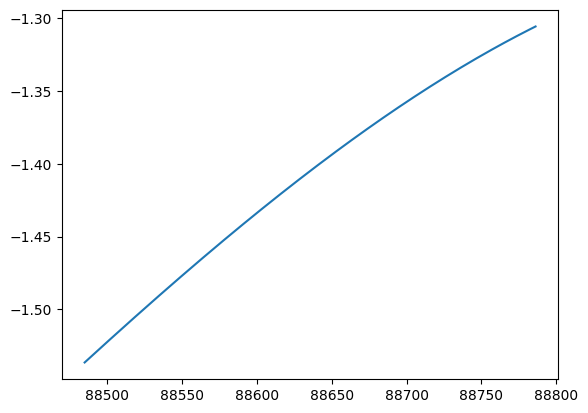

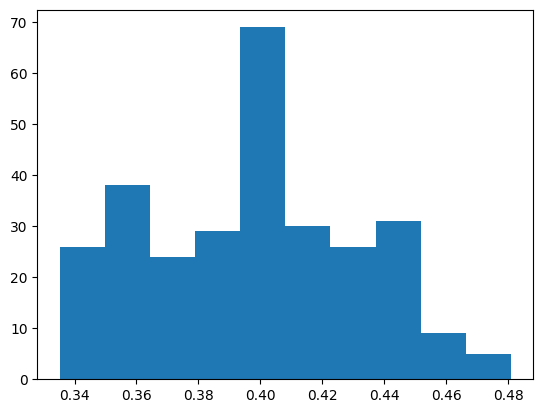

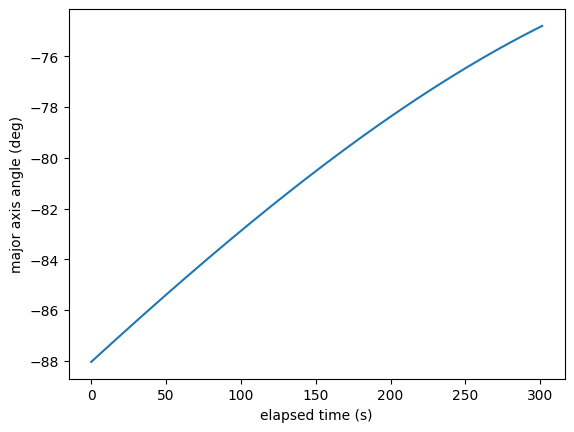

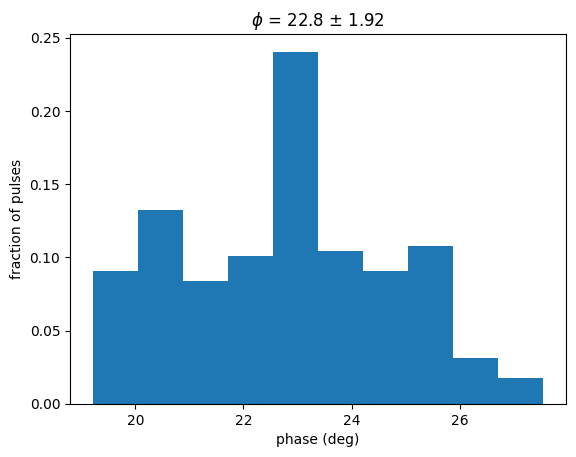

In [4]:
#examples from above

#basic
f = calibrationdata[2].fits[1]
plt.plot(f.nopulse.time, f.nopulse.theta)
plt.show()

f = pulsedata[1].fits[3]
plt.hist(f.pulse.phase)
plt.show()

#fancy
f = calibrationdata[2].fits[1]
plt.plot(f.nopulse.time-f.nopulse.time[0], np.rad2deg(f.nopulse.theta))
plt.xlabel('elapsed time (s)')
plt.ylabel('major axis angle (deg)')
plt.show()

f = pulsedata[1].fits[3]
plt.hist(np.rad2deg(f.pulse.phase),weights = np.ones_like(f.pulse.phase)/f.pulse.phase.size)
plt.xlabel('phase (deg)')
plt.ylabel('fraction of pulses')
plt.title(r'$\phi$ = {:.1f} $\pm$ {:.2f}'.format(np.mean(np.rad2deg(f.pulse.phase)), np.std(np.rad2deg(f.pulse.phase))))
plt.show()




```
# This is formatted as code
```

#Now it's your turn

Pick an experiment - let's say the 3rd fit from the 2nd calibration data set, but if this looks funky when you go to do your assignment, pick another one.

In the example code, I'm using `f` as shorthand for `calibrationdata[1].fits[2]`, and you should too

For this experiment, please 
1. Plot the minor axis vs. time. Remeber you will use the `nopulse` structure - the minor axis is stored in `f.nopulse.b`. Whether you make this plot basic or fancy is up to you
1. Make a plot of the predicted and measured rotation rates vs. time 
  1. Calculate the predicted anharmonic precession rate: $\Omega_{pred} = \frac{3 \pi}{4 T} \frac{a b}{L^2}$ (or $\frac{3}{8} \omega \frac{a b}{L^2}$ ) Hint: remember that the period is stored in `f.period` and the length is stored in `f.L`
  1. Calculate the measured precession rate:  $\Omega_{m} = \frac{d\theta}{d t}$. Hint: if `x` and `t` are numpy arrays, then `np.gradient(x,t)` = $\frac{d x}{d t}$. Note the order of `x` and `t`
  1. On the same (new) set of axes, plot the predicted precession rate $\Omega_{pred} + \Omega_{foucault}$ vs. time ($\Omega_{foucault}$ = `omega_foucault`), and plot the measured precession rate vs. time. Convert everything to degrees per hr
1. On a new set of axes, make a scatter plot of $\Omega_m$ vs. $\Omega_{pred} + \Omega_{foucault}$, again in degrees/hr

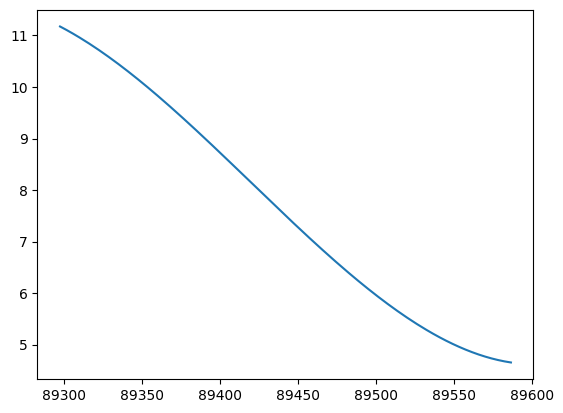

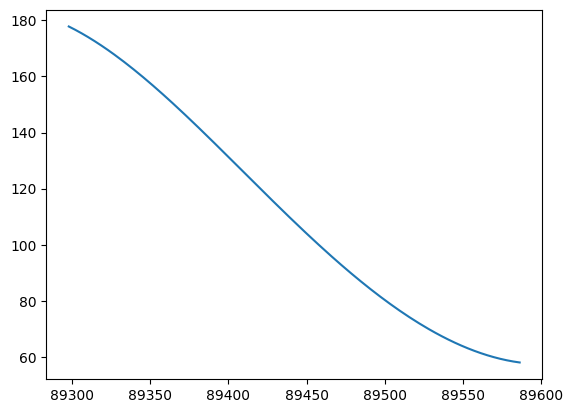

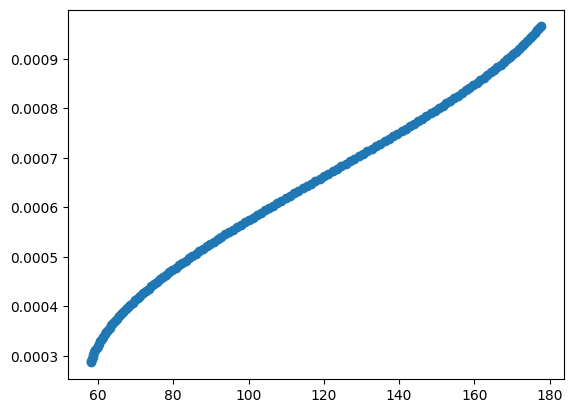

In [5]:
#your code here
f = calibrationdata[2].fits[3]
plt.plot(f.nopulse.time, f.nopulse.b)
plt.show()

pred = ((3*np.pi)/(4*f.period))*((f.nopulse.a*f.nopulse.b)/(f.L**2))
mprec = np.gradient(f.nopulse.theta,f.nopulse.time)
plt.plot(f.nopulse.time,(pred+omega_foucault)*deghr) 
plt.show()

plt.scatter((pred+omega_foucault)*deghr, mprec);

#Ok, let's calibrate!

I need you to write three functions

`predictedPrecession_calibration(f)`, which will calculate the predicted rate of rotation at each time point for a given calibration experiment f

`measuredPrecession_calibration(f)`, which will calculate $d\theta/dt$ at each time point for a given calibration experiment f

These just adapt what you did above. 


`lifetime_calibration(f)`, which will calculate the major axis lifetime (= twice the energy lifetime) for each calibration experiment.

Here, please fit a line: $\log(a) = -m(t-t0) + b$ and return the lifetime $\tau = -1/m$ (hints `np.polyfit` and `np.log`)


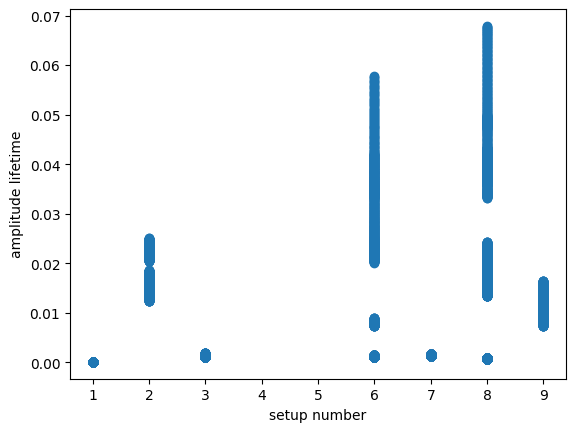

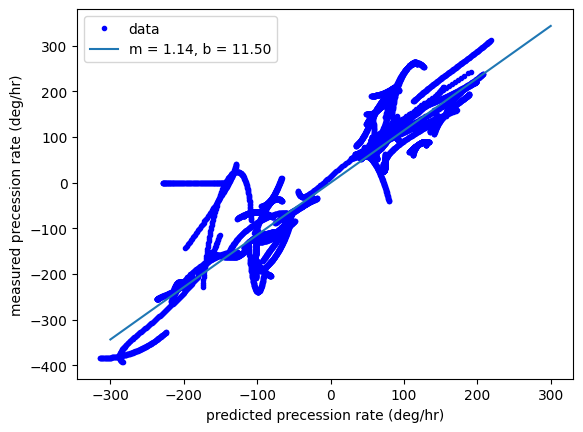

In [7]:
def predictedPrecession_calibration(f):
  #calculates the predicted precession rate (in rad/s) for a calibration experiment
  #input f = fit structure from a dataset
  #output numpy array: 3/8 omega ab/L^2 + omega_foucault evaluated at each time point in f.nopulse.time
  a = f.nopulse.a
  b = f.nopulse.b
  w = 2*np.pi/f.period
  L = f.L
  return (3/8)*w*((a*b)/(L**2)) + omega_foucault

def measuredPrecession_calibration(f):
  #calculates the precession rate (in rad/s) of the major axis 
  #input f = fit structure from a dataset
  #output numpy array: d theta/ dt
  theta = f.nopulse.theta
  t = f.nopulse.time
  return np.gradient(theta,t)

def lifetime_calibration(f):
  #calculates the amplitude (not energy or amplitude squared lifetime) in seconds for a calibration experiment
  #input f = fit structure from a dataset
  #output float = lifetime in seconds
  a = f.nopulse.a
  t = f.nopulse.time

  return  a/t ############################################################################################################
  
#test your code here - if you wrote the lifetime function correctly, you should see a scattered set of circles showing individual lifetime measurements for each setup
#see next cell for an explanation of `applyFunctionToSet`
lifetime, setup, _ = applyFunctionToSet(lifetime_calibration, calibrationdata)
plt.scatter(setup[setup < 20], lifetime[setup < 20])
plt.xlabel('setup number')
plt.ylabel('amplitude lifetime')

#test your code here - if you wrote the predicted and measured precession functions correctly, you should see a line relating predicted and measured rates
pp = applyFunctionToSet(predictedPrecession_calibration, calibrationdata)[0]
rp = applyFunctionToSet(measuredPrecession_calibration, calibrationdata)[0]

plt.show()
plt.plot(pp*deghr,rp*deghr, 'b.')
p = np.polyfit(pp,rp,1)
px = np.linspace(-300,300)
plt.plot(px, p[0]*px + p[1])
plt.xlabel('predicted precession rate (deg/hr)')
plt.ylabel('measured precession rate (deg/hr)')
plt.legend(('data','m = {:.2f}, b = {:.2f}'.format(p[0], deghr*p[1])))
plt.show()

#Question 

Does the measured precession rate match the predicted precession rate for the calibration data sets? 

Yes, it does seem like the fit line is an accurate representation of the measured data.

If it doesn't that means there's something wrong with the data or your code. As of this writing, the data are OK (and plural!) so check your code.



#A new function for you to use

```
value, section, setup = applyFunctionToSet(fun, dataset)
# for just value
# value = applyFunctionToSet(fun, dataset)[0]
# or
# value,*_ = applyFunctionToSet(fun, dataset) 
```

This function loops through all the data sets and runs `fun` on the fits from each one. It then gives you the output of that function concatenated together as one big array as the first return value

It also returns two other arrays - section, which is the section number associated with each data point, and setup, which is the setup number associated with each data point

So for instance, to find the lifetimes only from the Tuesday AM section (section 1), I would write

```
lifetime, setup, section = applyFunctionToSet(lifetime_calibration, calibrationdata)
sectionOneLifetime = lifetime[section == 1]
```

If I only want the lifetimes but don't care about the section number, I would write
```
lifetime, *_ = applyFunctionToSet(lifetime_calibration, calibrationdata)
```
or
```
lifetime = applyFunctionToSet(lifetime_calibration, calibrationdata)[0]
```

For `dataset`, you can put in a list of datasets (e.g. `calibrationdata` or `pulsedata`) or you can use an individual data set (e.g. `calibrationdata[2]`)

I used this function in the test code above - look at it and make sure  you understand how it works.


#Calculate the amplitude lifetime for each setup
For now we'll ignore the section data, but we can look at if things are bonkers

1. Calculate the lifetime and setup number for each fit in the `calibrationdata` set using `applyFunctionToSet` and `lifetime_calibration`. Hint: I've pretty much told you exactly how to do this above. If you don't want to store the setup number, it's conventional to replace the variable name with `_`

1. Call the number of setups nsetups. Let's define `nsetups = 200` - it doesn't matter as long as it's bigger than the actual number of setups, and since we used `setupNumber = 99` to indicate you didn't enter one, it needs to be bigger than this. Create a numpy array called `median_lifetime` of length `nsetups` filled with `np.nan`. Hint: you can use `np.full` or a `for` loop

1. Using a for loop iterating over a reasonable number of setups `for i in range(20):`, 
  1. check to see if you have any lifetime data matching that setup (`np.any()` is your friend here). 
  1. If you have any lifetime data for that setup, calculate the **median** (`np.median`) of all lifetimes for that setup and store the result in `median_lifetime[i]` Hint: logical indexing is your friend here. Remember logical indexing looks like `y[x == i]` 
  1. print the setup number and the median so you can see if it looks reasonable

1. Calculate the median of all lifetimes


1. Set any value of `median_lifetime` that is nan (use np.isnan) to the median of all lifetimes. This means that if we don't have any calibration data for that setup, just use the calibration data for all setups


1. Iterate over all fits in the pulse data set and add a field `lifetime` equal to the median lifetime for that fit (`f.lifetime = median_lifetime[f.setupNumber]`). You can do this with a set of nested for loops.

```
for d in pulsedata: 
  for f in d.fits:
    ...
```

In [8]:
nsetups = 200

lifetime, setup, section = applyFunctionToSet(lifetime_calibration, calibrationdata)
median_lifetime = np.full((nsetups), np.nan)

toAvg = []
for i in range(20):
  if(np.any(lifetime[setup==i])):
    median_lifetime[i] = np.median(lifetime[setup==i])
    toAvg.append(np.median(lifetime[setup==i]))
    
mid = np.median(toAvg)

for i in range(nsetups):
  if(np.isnan(median_lifetime[i])):
    median_lifetime[i] = mid

for d in pulsedata: 
  for f in d.fits:
    f.lifetime = median_lifetime[f.setupNumber]

#Let's figure out the rotation induced by the pulse

We need 4 more functions

1. `anharmonicAndFoucaultRotation_pulse(f)` - calculates the amount you expect the orbit to rotate between pulses (this is an angle - rate * time, not a rate) =
$(\frac{3}{8}\omega \frac{a b}{L^2} + \Omega_{foucault})\Delta t$

1. `measuredRotation_pulse(f)` - just calculates the difference between $\theta$ at subsequent times - compute using `np.gradient(..)` with just one argument - aw heck, I'll just write this for you it's so easy

1. `rotationPrefactor` - this is the thing that multiplies cot($2 \phi$) (or whatever you pick from Schumacher and Tarbet) = $\frac{-2 b \Delta a}{a^2-b^2}$

The only tricky bit is that you need to include the effects of amplitude decay (the coil is pushing harder than you think if you just look at the change in amplitude)

$\Delta a = $grad$(a) + a * $grad$(t)/\tau$ where grad is computed using `np.gradient` and no arguments. The first term is how much a is changed by the pulse, the second term is how much a would have decreased if the coil didn't turn on. Together they measure the effect of the coil 

1. `pulsePhase(f)` - literally just return the list of pulse phases so we can get them all using applyFunctionToSet. You don't really need this function; you could just use a `lambda` expression. Heck, I'll write this one for you too

In [9]:
def anharmonicAndFoucaultRotation_pulse(f):
  a = f.pulse.a
  b = f.pulse.b
  L = f.L
  w = 2*np.pi/f.period
  t = f.pulse.time
  rate = (3/8)*w*((a*b)/(L**2)) + omega_foucault
  dt = np.gradient(t) 
  return rate*dt

def measuredRotation_pulse(f):
  return np.gradient(f.pulse.theta)

def rotationPrefactor(f):
  lifetime = f.lifetime
  a = f.pulse.a
  b = f.pulse.b
  L = f.L
  w = 2*np.pi/f.period
  t = f.pulse.time
  da = np.gradient(a)+a*np.gradient(t)/lifetime
  ans = (-2*b*da)/((a**2)-(b**2))
  #your code here
  return ans

def pulsePhase(f):
  return f.pulse.phase

#Now we find out the answer!

Here you'll use one other function I've written (introduced in earlier labs)
```
(m,m_e) = fitLineThroughZero(x,y)
```
finds the best fit to $y = mx$ (calculated as $m =\frac{\sum_i x_i y_i}{\sum x_i^2}$) `m_e` is the error in the fit estimate, *assuming all the measurements are independent,* which isn't true -- a correction is incorporated below

1. gather together the measured rotation, predicted (aharmonic and foucault only) rotation, rotation prefactor, and phase for all the pulses in all the experiments. For example 
```
measured_rotation = applyFunctionToSet(measuredRotation_pulse, pulsedata)[0] 
```

1. calculate the `residual_rotation` as measured rotation - predicted rotation

1. We want to group all pulses with similar phases together for analysis. For instance we might want to look at all pulses within +/- 2 phase degrees of a central value. We also want to define a range of interest, so we don't end up looking at messed up / error pulses. I've written this for you, but I want you to understand it
  1. Define `minphase = 20` and `maxphase = 75`. These end up being potentially approximate (up to `phasebin` off)
  1. Define `phasebin` = 4
  1. `nbins` is the number of bins (to initialize the arrays)
  1. `idx` is the bin index, which indicates which phases get grouped together. `floor_divide(x,y)` is the largest integer $n$ s.t. $n y  <= x$  (divide and round down)
  1. bin0 is the starting bin - the bin that contains `minphase`
  1. Initialize arrays for use laster
    1. binhasdata - whether there are any pulses in a particular bin
    1. meanphase - the average phase of pulses in that bin
    1. slope - the relation between residual rotation and the rotation prefactor
    1. slope_eb - the uncertainty in that estimate

1. run a for loop over the valid bin values `for i in range(bin0,nbins):`
  1. `binhasdata[i]` is true if any values of idx == i 
  1. if `binhasdata[i]` then continue analysis
    1. `meanphase[i]` is the mean (`np.mean`) of all phases for which idx == i (hint logical indexing, this whole thing is all logical indexing)
    1. use `(m,m_e) = fitLineThroughZero` to find a relation between of the form `residual_rotation` = m`*rotation_prefactor` **only for those points where idx == i** (ie only for pulses within the phase bin)
    1. assign 'm' to 'slope[i]'
    1. the calculation of the error assumes that each data point is independent. But in fact, these points all come from the same smooth curve. So you need to multiply by the square root of the number of pulses you think constitute one independent measurement. As a ballpark, I'm guessing 100 pulses, so use a factor of 10, but this is clearly a guesstimate. So assign `10*m_e` to `slope_eb`
    1. I've defined a quantity `doplot = True` This lets you turn off the plotting, if you want later. So in a block beginning `if doplot:`
      1. For only values where idx == i, plot the residual rotation (y axis) vs. the rotation prefactor (x axis) with black dots
      1. Add a magenta line showing the best fit line you calculated above
      1. Title the plot "phi = (mean phase), slope = (m), cot(2phi) = (1/tan(2phi))" where obviously the parts in () should contain calculated numbers

1. After the for loop, keep only the values that have data. e.g. `meanphase = meanphase[binhasdata]` (repeat for slope and slope_eb)



/usr/local/lib/python3.9/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


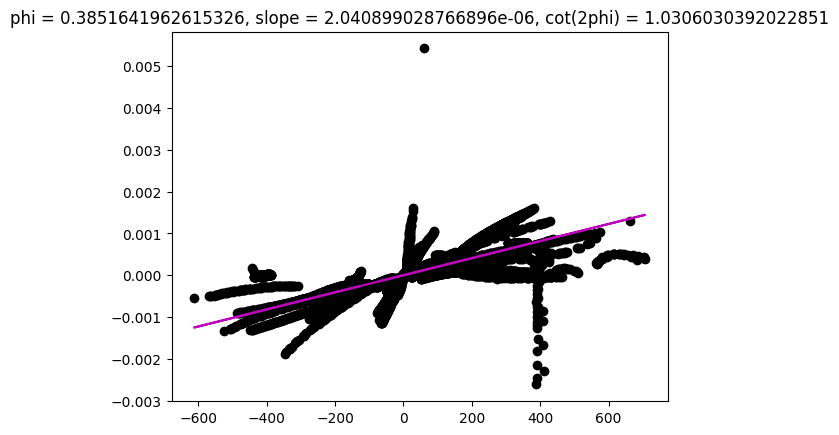

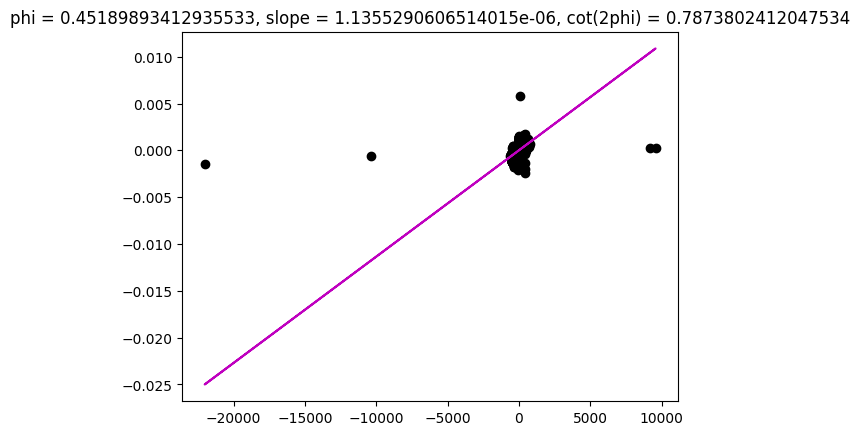

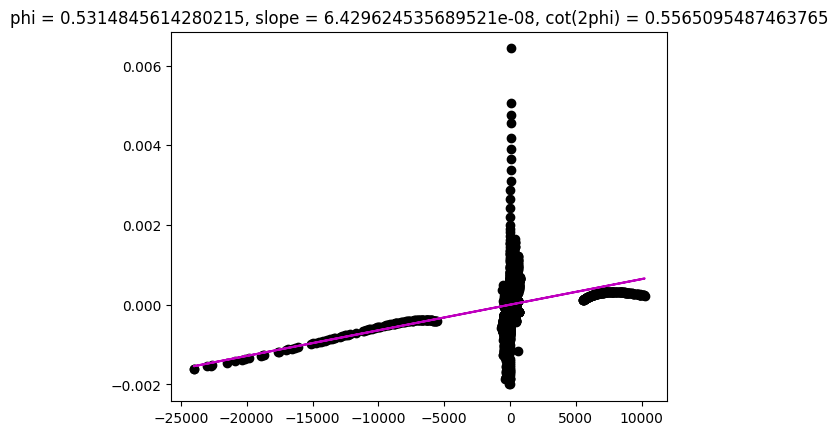

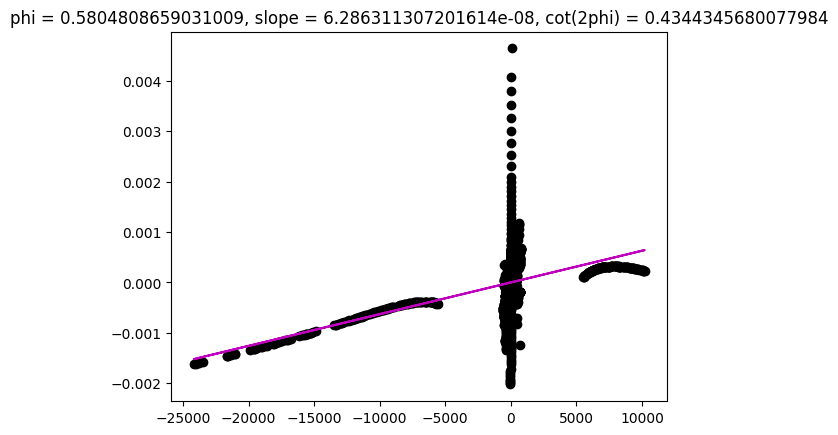

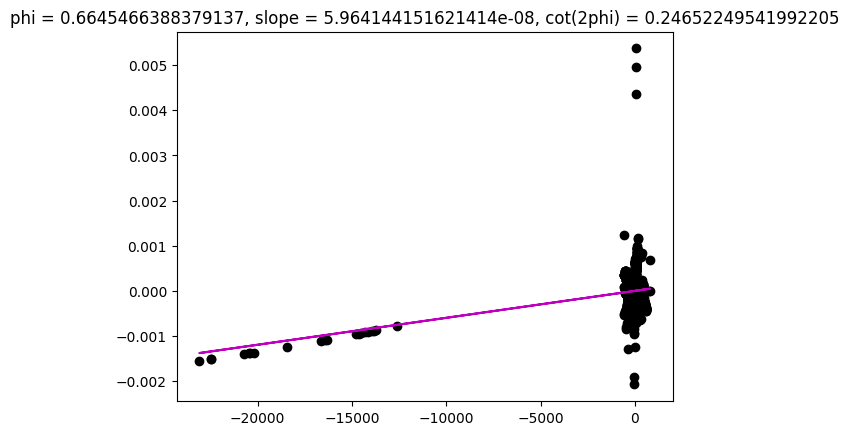

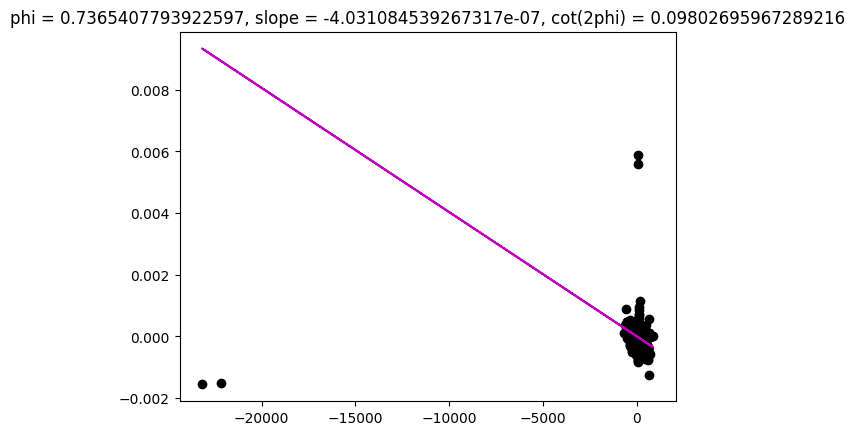

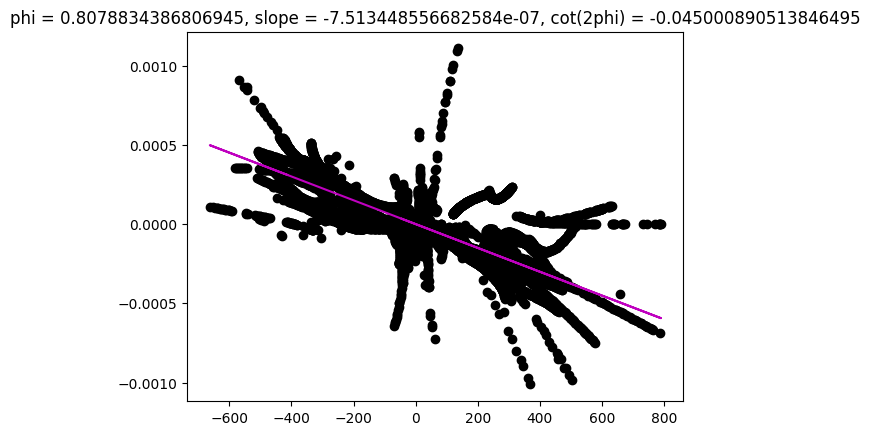

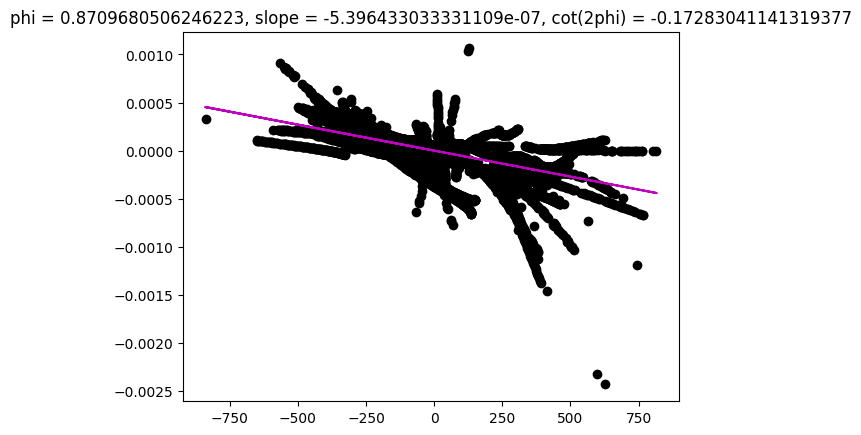

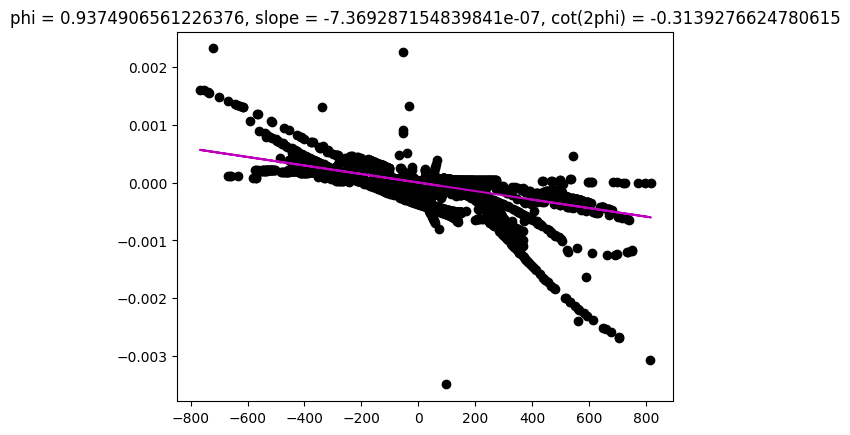

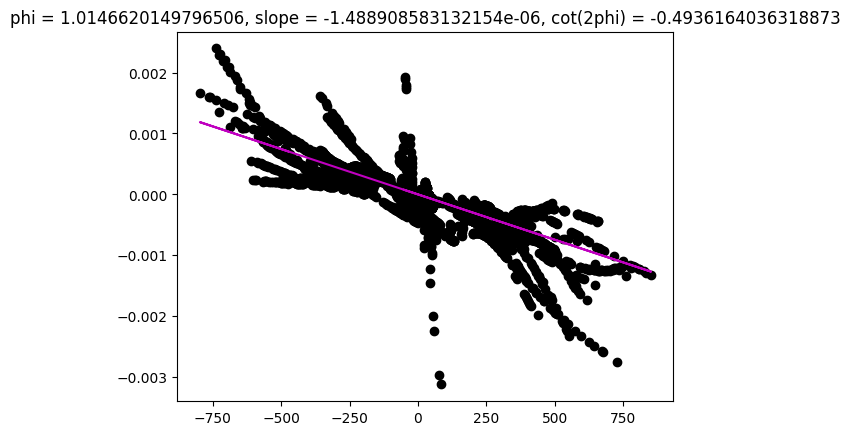

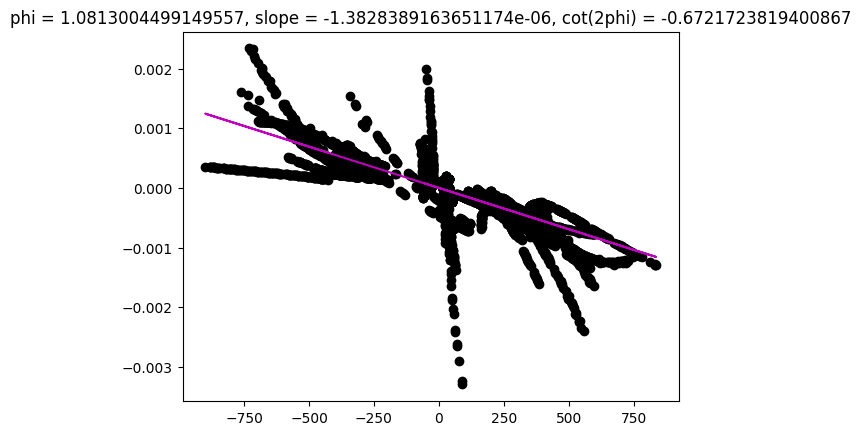

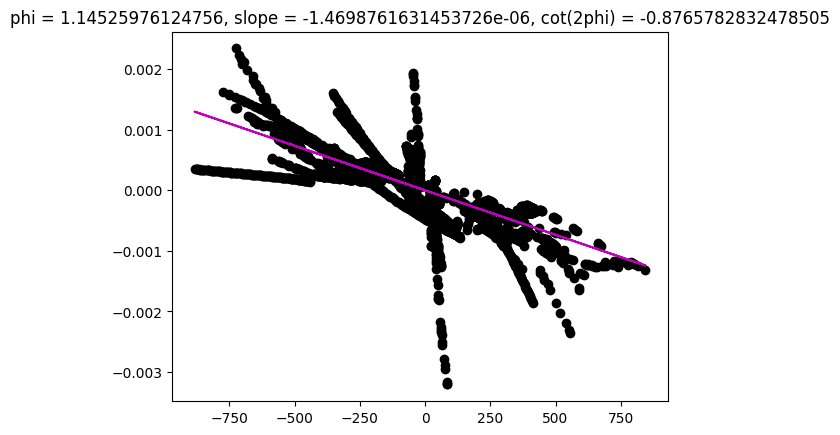

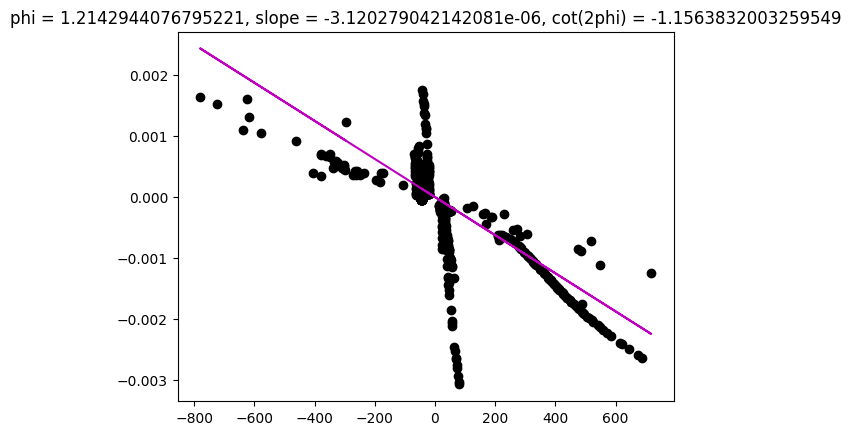

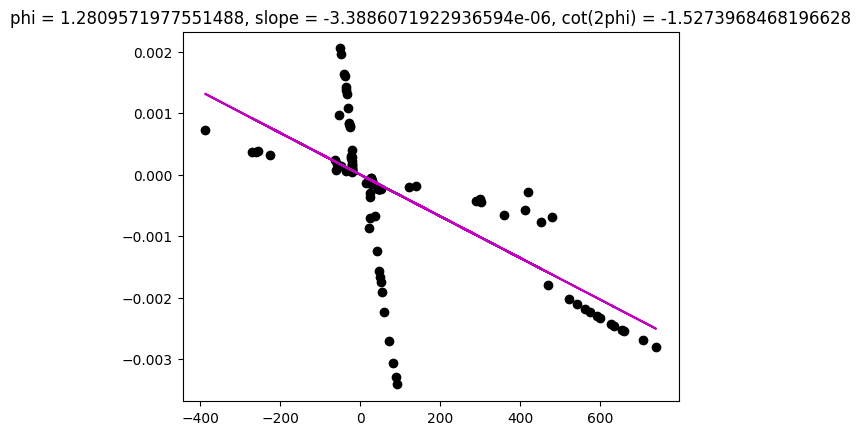

In [12]:
measured_rotation = applyFunctionToSet(measuredRotation_pulse, pulsedata)[0] 
predicted_rotation = applyFunctionToSet(anharmonicAndFoucaultRotation_pulse, pulsedata)[0] #Is this right? 
rotation_prefactor = applyFunctionToSet(rotationPrefactor, pulsedata)[0] 
residual_rotation = measured_rotation - predicted_rotation
phase = applyFunctionToSet(pulsePhase, pulsedata)[0] 

#(m,m_e) = fitLineThroughZeroDiscardOutliers(x,y, sigma = 2)
#y = m(m +/- m_e)x
def fitLineThroughZeroDiscardOutliers(x,y, sigma = 2):
  valid = np.full_like(x, True, dtype=bool)
  res = np.zeros_like(x)
  for j in range(4):
    m = np.sum(x[valid]*y[valid])/np.sum(x[valid]**2)
    res[valid] = y[valid] - m*x[valid]
    valid = np.logical_and(valid, res**2 < sigma**2 * np.mean(res**2))
  m = np.sum(x[valid]*y[valid])/np.sum(x[valid]**2)
  m_e = np.sqrt(np.var(res[valid])/np.sum((x[valid]-np.mean(x[valid]))**2))
  return (m,m_e)

#my code to tod the setup in step 3
minphase = 20
maxphase = 75
phasebin = 4 #degrees
nbins = np.round(maxphase/phasebin).astype(int) #last bin has at least 1/2 phasebin before maxphase or it's excluded
idx = np.floor_divide(np.rad2deg(phase), phasebin).astype(int)
bin0 = np.floor_divide(minphase,phasebin)

binhasdata = np.full((nbins,), 0, dtype = bool)
meanphase = np.full((nbins,), np.nan)
slope = np.full((nbins,), np.nan)
slope_eb = np.full((nbins,), np.nan)
doplot = True

for i in range(bin0,nbins):
  #your code here
  binhasdata[i] = np.any(idx == i)
  if(binhasdata[i]):
    meanphase[i] = np.mean(phase[idx == i])
    (m,m_e) = fitLineThroughZeroDiscardOutliers(rotation_prefactor[idx == i],residual_rotation[idx == i],sigma=2)
    slope[i] = m
    slope_eb[i] = 10*m_e
    if doplot:
      plt.scatter(rotation_prefactor[idx == i],residual_rotation[idx == i], color = 'k')
      plt.plot(rotation_prefactor[idx == i],rotation_prefactor[idx == i]*m,color = 'm')
      plt.title(f'phi = {meanphase[i]}, slope = {m}, cot(2phi) = {1/np.tan(2*meanphase[i])}')
      plt.show()
#your code here
meanphase = meanphase[binhasdata]
slope = slope[binhasdata]
slope_eb = slope_eb[binhasdata]

#What you've done all the work for

1. Make an error bar plot of the meanphase(convert to degrees) (x) slope (y) and slope_eb, with 'o' markers
1. Overlay with the predictions of our model $1/\tan(2\phi)$ and of Schumacher and Tarbet (do both $0.5(\pi/2 - \phi)/\tan(\phi)$ and $0.5(\pi/2 - \phi)/\sin(\phi)$
1. When I looked at the Schumacher paper, I'm pretty sure it should be $0.5(\pi/2 - \phi)/\tan(\phi)$, but in my notes I have $0.25(\pi/2 - \phi)/\tan(\phi)$. Plot that one too


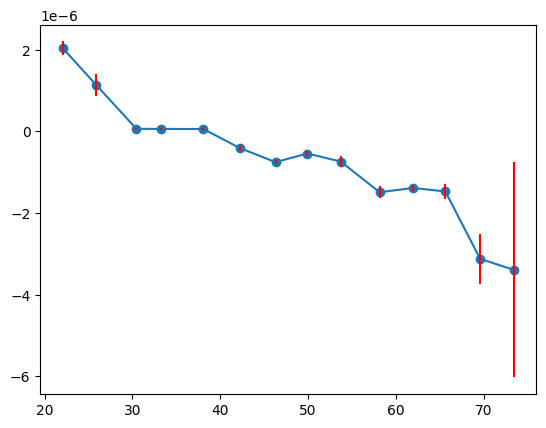

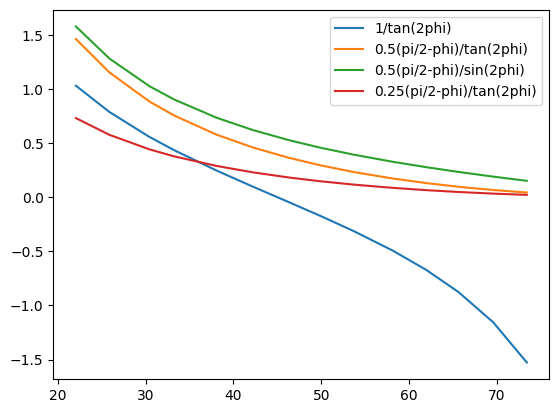

In [16]:
plt.errorbar(meanphase*(180/np.pi),slope,yerr=slope_eb,marker = 'o',ecolor='r',barsabove=True)
plt.show()
plt.plot(meanphase*(180/np.pi),1/np.tan(2*meanphase), label = '1/tan(2phi)')
plt.plot(meanphase*(180/np.pi),(0.5*(np.pi/2-meanphase))/np.tan(meanphase), label = '0.5(pi/2-phi)/tan(2phi)')
plt.plot(meanphase*(180/np.pi),(0.5*(np.pi/2-meanphase))/np.sin(meanphase), label = '0.5(pi/2-phi)/sin(2phi)')
plt.plot(meanphase*(180/np.pi),(0.25*(np.pi/2-meanphase))/np.tan(meanphase), label = '0.25(pi/2-phi)/tan(2phi)')
plt.legend()
plt.show()

#Questions

Do the data support (or disprove) the following statements (explain)?

1. Applying the drive force rotates the orbit by an amount proportional to $\frac{2b \Delta a}{a^2 - b^2}$

The data supports this statement, looking at the trend.

1. Applying the drive force rotates the orbit by an amount proportional to $ \cot(2\phi)$

Looking at the data, it does seem like the data is proportional to $\frac{2b \Delta a}{a^2 - b^2}$ however it seems off by a factor of $10^6$

1. Applying the drive force rotates the orbit by an amount proportional to $(\pi/2 - \phi)/\tan(\phi)$ or $(\pi/2 - \phi)/\sin(\phi)$

No it does not seem to be proportional to these since these models do not cross 0. 

If the answer to 2 was yes and 3 was no, expain what the key differentating feature of the data is. 

The models in 3 do not cross 0.

Does the data support our final model $\Delta \theta = -\frac{2b \Delta a}{a^2 - b^2} \cot(2 \phi)$

Yes, it does.
